In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skopt import BayesSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import math
from sklearn.linear_model import LinearRegression
from skopt.plots import plot_convergence
from skopt.space import Real, Integer, Categorical

In [8]:
from ucimlrepo import fetch_ucirepo 

In [42]:
# fetch dataset 
air_quality = fetch_ucirepo(id=360) 
  
# data (as pandas dataframes) 
origin_data = air_quality.data.features

In [21]:
origin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   int64  
 4   NMHC(GT)       9357 non-null   int64  
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   int64  
 7   NOx(GT)        9357 non-null   int64  
 8   PT08.S3(NOx)   9357 non-null   int64  
 9   NO2(GT)        9357 non-null   int64  
 10  PT08.S4(NO2)   9357 non-null   int64  
 11  PT08.S5(O3)    9357 non-null   int64  
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
dtypes: float64(5), int64(8), object(2)
memory usage: 1.1+ MB


In [3]:
# Constant
VALIDATION_PORTION = 0.2
TARGET = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)', 'NMHC(GT)']
LAG=[1, 6, 12, 24]
TARGET_LAG = [t + f"_lag{l}" for t in TARGET for l in LAG]

In [ ]:
def read_data(file_paths: list) -> pd.DataFrame:
    '''
    Reads multiple CSV files and combines them into a single DataFrame.
    '''
    return

In [4]:
df = pd.read_csv('data/temporal_features/features_hourly_master_all_targets.csv')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 53 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   datetime              9357 non-null   object 
 1   CO(GT)                8024 non-null   float64
 2   PT08.S1(CO)           9066 non-null   float64
 3   NMHC(GT)              942 non-null    float64
 4   C6H6(GT)              9066 non-null   float64
 5   PT08.S2(NMHC)         9066 non-null   float64
 6   NOx(GT)               8169 non-null   float64
 7   PT08.S3(NOx)          9066 non-null   float64
 8   NO2(GT)               8167 non-null   float64
 9   PT08.S4(NO2)          9066 non-null   float64
 10  PT08.S5(O3)           9066 non-null   float64
 11  T                     9066 non-null   float64
 12  RH                    9066 non-null   float64
 13  AH                    9066 non-null   float64
 14  Hour                  9357 non-null   int64  
 15  Weekday              

In [12]:
def create_target(dataset: pd.DataFrame, target_columns: list, lag_steps: list) -> pd.DataFrame:
    '''
    Creates lagged target variables in the dataset.
    '''
    dataset_target = dataset.copy()
    for target in target_columns:
        for lag in lag_steps:
            dataset_target[f"{target}_lag{lag}"] = dataset_target[target].shift(-lag)
    return dataset_target

def data_column_preprocessing(df: pd.DataFrame) -> pd.DataFrame:
    '''
    delete datetime, create Year and create target lag features
    '''
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['Year'] = df['datetime'].dt.year
    df = df.drop(columns=['datetime'])
    df = create_target(df, TARGET, LAG)
    
    return df

In [13]:
data_column_preprocessing(df)

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),...,NO2(GT)_rollmean_24,Year,CO(GT)_lag12,C6H6(GT)_lag12,NOx(GT)_lag12,NO2(GT)_lag12,NMHC(GT)_lag1,NMHC(GT)_lag6,NMHC(GT)_lag12,NMHC(GT)_lag24
0,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,...,113.000000,2004,0.7,1.6,34.0,48.0,112.0,31.0,16.0,307.0
1,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,...,102.500000,2004,1.1,3.2,98.0,82.0,88.0,31.0,29.0,461.0
2,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,...,106.333333,2004,2.0,8.0,174.0,112.0,80.0,24.0,64.0,401.0
3,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,...,110.250000,2004,2.2,9.5,129.0,101.0,51.0,19.0,87.0,197.0
4,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,...,111.400000,2004,1.7,6.3,112.0,98.0,38.0,14.0,77.0,61.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,3.1,1314.0,NaN,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,...,120.708333,2005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9353,2.4,1163.0,NaN,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,...,123.375000,2005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9354,2.4,1142.0,NaN,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,...,125.500000,2005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9355,2.1,1003.0,NaN,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,...,128.416667,2005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
def create_time_features(dataset: pd.DataFrame) -> pd.DataFrame:
    dataset_time = dataset.copy()
    dataset_time['datetime'] = pd.to_datetime(dataset_time['Date'] + ' ' + dataset_time['Time'])
    dataset_time['hour'] = dataset_time['datetime'].dt.hour
    dataset_time['weekday'] = dataset_time['datetime'].dt.dayofweek
    dataset_time['month'] = dataset_time['datetime'].dt.month
    dataset_time['year'] = dataset_time['datetime'].dt.year
    dataset_time.drop(columns=['Date', 'Time', 'datetime'], inplace=True)
    return dataset_time

In [47]:
create_time_features(create_target(origin_data, TARGET, LAG))

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),...,NO2(GT)_lag12,NO2(GT)_lag24,NMHC(GT)_lag1,NMHC(GT)_lag6,NMHC(GT)_lag12,NMHC(GT)_lag24,hour,weekday,month,year
0,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,...,48.0,151.0,112.0,31.0,16.0,307.0,18,2,3,2004
1,2.0,1292,112,9.4,955,103,1174,92,1559,972,...,82.0,172.0,88.0,31.0,29.0,461.0,19,2,3,2004
2,2.2,1402,88,9.0,939,131,1140,114,1555,1074,...,112.0,165.0,80.0,24.0,64.0,401.0,20,2,3,2004
3,2.2,1376,80,9.2,948,172,1092,122,1584,1203,...,101.0,136.0,51.0,19.0,87.0,197.0,21,2,3,2004
4,1.6,1272,51,6.5,836,131,1205,116,1490,1110,...,98.0,85.0,38.0,14.0,77.0,61.0,22,2,3,2004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,3.1,1314,-200,13.5,1101,472,539,190,1374,1729,...,NaN,NaN,-200.0,NaN,NaN,NaN,10,0,4,2005
9353,2.4,1163,-200,11.4,1027,353,604,179,1264,1269,...,NaN,NaN,-200.0,NaN,NaN,NaN,11,0,4,2005
9354,2.4,1142,-200,12.4,1063,293,603,175,1241,1092,...,NaN,NaN,-200.0,NaN,NaN,NaN,12,0,4,2005
9355,2.1,1003,-200,9.5,961,235,702,156,1041,770,...,NaN,NaN,-200.0,NaN,NaN,NaN,13,0,4,2005


In [48]:
def split_data(dataset: pd.DataFrame) -> tuple:
    '''
    Splits the dataset into training and test sets.
    '''
    Y_train = dataset[dataset['year'] == 2004][TARGET_LAG]
    X_train = dataset[dataset['year'] == 2004].drop(columns=TARGET_LAG)
    Y_test = dataset[dataset['year'] == 2005][TARGET_LAG]
    X_test = dataset[dataset['year'] == 2005].drop(columns=TARGET_LAG)
    return X_train, Y_train, X_test, Y_test

In [49]:
X_train, Y_train, X_test, Y_test = split_data(create_time_features(create_target(origin_data, TARGET, LAG)))

In [80]:
'''
Define neural network model using PyTorch
'''

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, RegressorMixin

class TorchRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, lr=1e-3, hidden=64, epochs=20):
        self.lr = lr
        self.hidden = hidden
        self.epochs = epochs
        self.model = None
    
    def _build_model(self, input_dim, output_dim=1):
        return nn.Sequential(
            nn.Linear(input_dim, self.hidden),
            nn.ReLU(),
            nn.Linear(self.hidden, output_dim)
        )

    def fit(self, X, Y):
        X = torch.tensor(X, dtype=torch.float32)
        Y = torch.tensor(Y, dtype=torch.float32).view(-1, Y.shape[1])

        self.model = self._build_model(X.shape[1], output_dim=Y.shape[1])
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.MSELoss()

        for _ in range(self.epochs):
            optimizer.zero_grad()
            pred = self.model(X)
            loss = criterion(pred, Y)
            loss.backward()
            optimizer.step()
        return self

    def predict(self, X):
        X = torch.tensor(X, dtype=torch.float32)
        self.model.eval()
        with torch.no_grad():
            pred = self.model(X).numpy()
        return pred

In [81]:
# Predefine attributes
model = TorchRegressor()

pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),  
    ('model', model)
])

hyperspace = {
    "model__lr": Real(1e-4, 1e-1, prior="log-uniform"),
    "model__hidden": Integer(16, 256),
    "model__epochs": Integer(5, 50)
}

ps = PredefinedSplit(
    test_fold=np.concatenate([
        -np.ones(int(len(X_train)*(1-VALIDATION_PORTION))),   # train
        np.zeros(int(len(X_train)*VALIDATION_PORTION))        # validation
    ])
)

opt = BayesSearchCV(
    estimator=pipeline,  
    search_spaces=hyperspace,
    cv=ps,
    n_iter=32,
    n_jobs=-1,
    verbose=0,
    random_state=42,
    scoring='neg_root_mean_squared_error'
)
opt.fit(X_train.to_numpy(), Y_train.to_numpy())

best_model = opt.best_estimator_
best_params = opt.best_params_

Y_pred = best_model.predict(X_test.to_numpy())
metrics = {}
metrics['rmse'] = np.sqrt(np.mean((Y_pred - Y_test.to_numpy())**2))

g:\code\COMP9417 Project\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(50), np.int64(256), 0.1] before, using random point [np.int64(21), np.int64(122), 0.0284289020505174]
  warnings.warn(
g:\code\COMP9417 Project\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(50), np.int64(256), 0.1] before, using random point [np.int64(10), np.int64(133), 0.018524945676790347]
  warnings.warn(
g:\code\COMP9417 Project\.venv\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(47), np.int64(256), 0.1] before, using random point [np.int64(41), np.int64(127), 0.00014738313251235437]
  warnings.warn(
g:\code\COMP9417 Project\.venv\Lib\site-packages\sklearn\pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other method

In [82]:
def plot_rmse(ax, rmses: pd.Series):
    '''
    Plots RMSE over iterations.
    '''
    ax.scatter(rmses.index, rmses.values, marker='o')
    ax.set_xlabel('models')
    ax.set_ylabel('RMSE')
    ax.set_title('RMSE over models')

def plot_metrics(metrics: dict):
    '''
    Plots the metrics.
    '''
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    plot_rmse(ax, pd.Series(metrics['rmse']))
    plt.show()


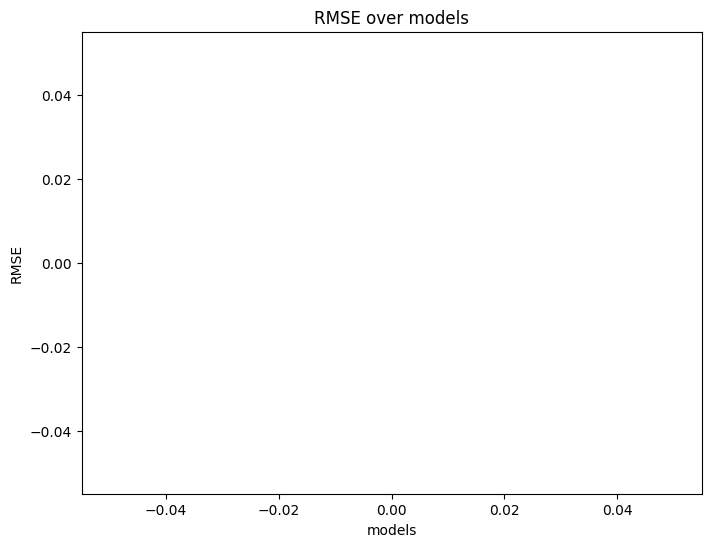

In [83]:
plot_metrics(metrics)